In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import timeit
import math
from models.spiking_layers import LinearLIF, Conv2dLIF
from models.spiking_models import SpikingModel
from models.conversion_method import spike_norm
from utils.dataloader import load_data
from utils.metrics import test, train, timesteps_performance
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_loader, test_loader, classes_labels = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
features = nn.Sequential(
    Conv2dLIF(3, 32, kernel_size=(5, 5), stride=(1, 1), padding="same", bias=False),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Conv2dLIF(32, 64, kernel_size=(5, 5), stride=(1, 1), padding="same", bias=False),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Conv2dLIF(64, 64, kernel_size=(3, 3), stride=(1, 1), padding="same", bias=False),
    nn.ReLU(inplace=True)
    )

classifier = nn.Sequential(
    LinearLIF(8*8*64, 256, bias=False),
    nn.ReLU(inplace=True),
    LinearLIF(256, 10, cumulative=True, bias=False)
    )

timesteps = 20
snn_model = SpikingModel(features, classifier, timesteps, device=DEVICE)
snn_model.to(DEVICE)

SpikingModel(
  (features): Sequential(
    (0): Conv2dLIF(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2dLIF(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2dLIF(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (7): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): LinearLIF(
      in_features=4096, 
      out_features=256, 
      bias=False, 
      leak=1.0, 
      threshold=1.0
    )
    (1): ReLU(inplace=True)
    (2): LinearLIF(
      in_features=256, 
      out_features=10, 
      bias=False, 
      leak=1.0, 
      threshold=1.0
    )
  )
)

In [5]:
class ANNModel(nn.Module):
  def __init__(self):
    super(ANNModel, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1),padding="same", bias=False),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding="same", bias=False),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding="same", bias=False),
        nn.ReLU(inplace=True)
    )

    self.classifier = nn.Sequential(
        nn.Linear(8*8*64, 256, bias=False),
        nn.ReLU(inplace=True),
        nn.Linear(256, 10, bias=False)
    )


  def forward(self, input):
    batch_size = input.shape[0]
    x = self.features(input)
    x = x.view(batch_size, -1)
    x = self.classifier(x)
    return x

ann_model = ANNModel()
ann_model.to(DEVICE)

optimizer_ann = optim.Adam(ann_model.parameters(), lr=0.0001)

In [6]:
max_epoch = 10

def training_ann():
  for epoch in range(1, max_epoch+1):
    train(ann_model, epoch, optimizer_ann, train_loader)
    _, _ = test(ann_model, "Epoch {0}".format(epoch), test_loader)

print(f'Total time for CNN: {timeit.timeit(training_ann, number=1)/60} min')

C:\Users\mapolina\Documents\venv\SNN-RNN2\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1: [0/50000] Loss: 2.2990615367889404
Epoch 1: [19200/50000] Loss: 1.6131585836410522
Epoch 1: [38400/50000] Loss: 1.469364881515503
Test result on Epoch 1: Avg loss is 1.423968119239807, Accuracy: 49.14999771118164%
Epoch 2: [0/50000] Loss: 1.3917052745819092
Epoch 2: [19200/50000] Loss: 1.1862833499908447
Epoch 2: [38400/50000] Loss: 1.2498136758804321
Test result on Epoch 2: Avg loss is 1.2356932163238525, Accuracy: 56.47999954223633%
Epoch 3: [0/50000] Loss: 1.3144872188568115
Epoch 3: [19200/50000] Loss: 1.2260392904281616
Epoch 3: [38400/50000] Loss: 1.2079885005950928
Test result on Epoch 3: Avg loss is 1.1346389413833617, Accuracy: 60.15999984741211%
Epoch 4: [0/50000] Loss: 1.251744031906128
Epoch 4: [19200/50000] Loss: 1.1797301769256592
Epoch 4: [38400/50000] Loss: 1.0349500179290771
Test result on Epoch 4: Avg loss is 1.0588533945083618, Accuracy: 62.69999694824219%
Epoch 5: [0/50000] Loss: 1.218316674232483
Epoch 5: [19200/50000] Loss: 1.0287237167358398
Epoch 5: [38

In [7]:
ann_loss, ann_acc = test(ann_model, "ANN after training", test_loader)

Test result on ANN after training: Avg loss is 0.8350642533302307, Accuracy: 71.33000183105469%


## ANN to SNN Conversion

In [8]:
snn_model = spike_norm(ann_model, snn_model, train_loader, DEVICE, 20)


 Missing keys : ['features.0.leak', 'features.0.threshold', 'features.3.leak', 'features.3.threshold', 'features.6.leak', 'features.6.threshold', 'classifier.0.leak', 'classifier.0.threshold', 'classifier.2.leak', 'classifier.2.threshold']
 Unexpected Keys: []
Conv2dLIF(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
Threshold: 7.937984943389893
Conv2dLIF(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
Threshold: 3.3365278244018555
Conv2dLIF(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
Threshold: 2.2808425426483154
LinearLIF(
  in_features=4096, 
  out_features=256, 
  bias=False, 
  leak=1.0, 
  threshold=2.2455596923828125
)
Threshold: 2.2455596923828125
LinearLIF(
  in_features=256, 
  out_features=10, 
  bias=False, 
  leak=1.0, 
  threshold=1.2508270740509033
)
Threshold: 1.2508270740509033


In [9]:
_, _ = test(snn_model, "SNN after conversion", test_loader)


Test result on SNN after conversion: Avg loss is 1.915435485649109, Accuracy: 39.099998474121094%


## Performance of SNN with Soft-reset for different number of timesteps

Test result on Timesteps=10: Avg loss is 2.302584887313843, Accuracy: 10.0%
Test result on Timesteps=20: Avg loss is 1.915435485649109, Accuracy: 39.099998474121094%
Test result on Timesteps=30: Avg loss is 1.2698163793563844, Accuracy: 57.32999801635742%
Test result on Timesteps=40: Avg loss is 1.0980204743385316, Accuracy: 61.88999938964844%
Test result on Timesteps=50: Avg loss is 1.1166686639785766, Accuracy: 63.63999938964844%
Test result on Timesteps=100: Avg loss is 1.8454912315368652, Accuracy: 66.08000183105469%
Test result on Timesteps=200: Avg loss is 3.736176052093506, Accuracy: 66.61000061035156%
Test result on Timesteps=300: Avg loss is 5.71307908706665, Accuracy: 66.62999725341797%
Test result on Timesteps=10: Avg loss is 2.2374371463775633, Accuracy: 17.59000015258789%
Test result on Timesteps=20: Avg loss is 1.2179180722236633, Accuracy: 57.73999786376953%
Test result on Timesteps=30: Avg loss is 1.2562997117042543, Accuracy: 62.6099967956543%
Test result on Timesteps=

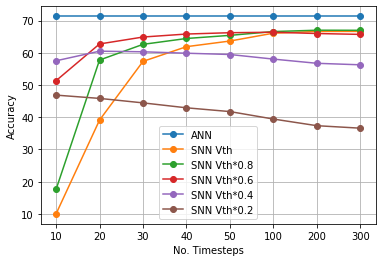

In [10]:
num_timesteps = [10, 20, 30, 40, 50, 100, 200, 300]

acc_list = []
scales = [1, 0.8, 0.6, 0.4, 0.2]
for scaling_factor in scales:
    _, acc_factor = timesteps_performance(snn_model, test_loader, num_timesteps, scaling_factor)
    acc_list.append(acc_factor)

fig = plt.figure("Acc vs Timesteps")
plt.plot([ann_acc]*len(num_timesteps), "-o")
for k in range(len(scales)):
    plt.plot(acc_list[k], "-o")
plt.legend(["ANN", "SNN Vth", "SNN Vth*0.8", "SNN Vth*0.6", "SNN Vth*0.4", "SNN Vth*0.2"])
plt.xlabel("No. Timesteps")
plt.ylabel("Accuracy")
plt.xticks(range(8), [str(k) for k in num_timesteps])
plt.grid(True)
plt.show()
